Author
Nikita Zakharov

Reference

[Notion ticket](https://www.notion.so/0616f7dfedd7459bae5f01a75f4fcc39)

Idea

RSS feed - an API that gives you the latest posts or news from the site. It used to be popular, it's rarer now, but it's still there somewhere!
RSS feeds are easier to parse than HTML page code, so it's much easier to do automatic parsing every day.
In addition, the news in such feeds is selected by humans, so you don't have to come up with heuristics that would filter news from non-news.

Results

- ~1k up-to-date feeds are saved locally, of which 212 were published in the past day
- removed hungarian and spanish sources


In [184]:
pip install feedparser

In [201]:
pip install spacy_langdetect

     |████████████████████████████████| 998 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993431 sha256=46a17e53321d2941bd1b3e735bcd379bea2eb24ae97cbfc37b2ae63f3beca8a0
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect


In [202]:
import pandas as pd
import feedparser
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from spacy_langdetect import LanguageDetector
import spacy

In [186]:
feeds = pd.read_csv('/content/Crypto feeds.csv')
urls = list(feeds.Feeds)
feeds = [feedparser.parse(url)['entries'] for url in urls]

removing empty feeds

In [187]:
non_zero_feeds = []
for i in range(len(feeds)):
  if len(feeds[i]) != 0:
    non_zero_feeds.append(feeds[i])
  else:
    print(pd.read_csv('/content/Crypto feeds.csv').iloc[i].Feeds)

https://blog.bitpanda.com/feed
https://coinatmradar.com/blog/feed/?x=1
https://www.coin.space/feed/
https://blog.coinspectator.com/feed/
https://bitcoinwarrior.net/feed/
https://belfrics.com/blog/feed/
https://www.hegion.com/feed
https://bitcoin-millionaire.com/feed/
https://blog.flitpay.in/feed/
https://paperblockchain.com/feed/
http://bitcoinmxn.com/feed
https://blog.spectrocoin.com/en/feed/
https://oilblockchain.news/feed/
https://coincurrencynews.com/feed/
https://www.goldsilveranalyst.com/feed
https://medium.com/feed/@satoshiknotabolo
https://blog.zebpay.com/feed
https://bitcoinspakistan.com/feed/
https://blog.feedspot.com/feed/
https://medium.com/feed/@nikita-monastyrskiy
https://medium.com/feed/buyucoin-talks


looking for feeds that do not have a date for each news item

In [188]:

for i in range(len(non_zero_feeds)):
  if ('published' not in non_zero_feeds[i][1].keys()) and ('pubDate' not in non_zero_feeds[i][1].keys()):
    print(i)


37


remove that feed

In [189]:
needed_feeds = non_zero_feeds[:39] + non_zero_feeds[40:]

In [190]:
for i in range(len(needed_feeds)):
  if ('summary_detail' not in needed_feeds[i][1].keys()):
    print(i)

2
6
49
63
71
72


convert to dataframe

In [223]:
news = pd.DataFrame(columns = {'title':[], 'date_published':[], 'source': []})

for k in needed_feeds:
  for j in range(len(k)):
    if (('summary_detail' in k[j].keys()) and ('title_detail' in k[j].keys())):
      if ('published' in k[j].keys()):
        unit = pd.DataFrame({'title': [k[j].title], 'date_published': [k[j].published], 'source': [k[j].summary_detail['base']]})
      elif ('pubDate' in k[j].keys()):
        unit = pd.DataFrame({'title': [k[j].title], 'date_published': [k[j].pubDate], 'source': [k[j].summary_detail['base']]})
      news = pd.concat([news, unit], axis = 0)
    if (('summary_detail' not in k[j].keys()) and ('title_detail' in k[j].keys())):
      if ('published' in k[j].keys()):
        unit = pd.DataFrame({'title': [k[j].title], 'date_published': [k[j].published], 'source': [k[j].title_detail['base']]})
      elif ('pubDate' in k[j].keys()):
        unit = pd.DataFrame({'title': [k[j].title], 'date_published': [k[j].pubDate], 'source': [k[j].title_detail['base']]})
      news = pd.concat([news, unit], axis = 0)

Drop duplicate news

In [224]:
news = news.drop_duplicates(subset = ['title', 'source'])

detect language of title, remove non-english text

In [225]:
news['language'] = list(map(lambda row: nlp(row)._.language['language'], news['title']))

In [226]:
news.language.value_counts()

en         2999
no           30
da           25
de           22
nl           16
tl           10
fr            8
it            6
ca            6
sv            5
id            5
af            4
ro            3
pt            3
es            3
et            2
tr            2
so            1
sw            1
UNKNOWN       1
Name: language, dtype: int64

In [227]:
news = news[news.language == 'en']

In [228]:
news['date'] = pd.to_datetime(news['date_published'], utc = True)
news['date'] = news['date'].dt.date
dates = pd.DataFrame(news.date.value_counts().reset_index()).sort_values('index')

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


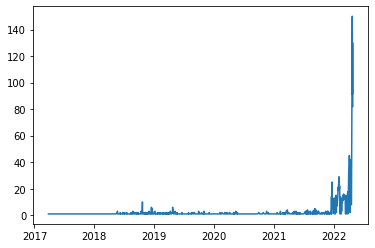

In [229]:
plt.plot(dates['index'], dates.date, linestyle = 'solid')

There is a certain amount of old news, they need to be removed

In [230]:
news = news[news.date > (pd.to_datetime("today") - np.timedelta64(1, 'M'))]
len(news)

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


1236

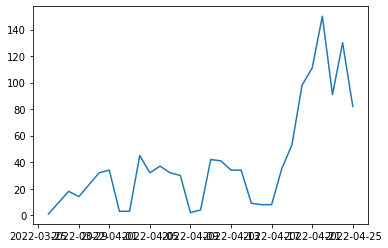

In [231]:
dates = pd.DataFrame(news.date.value_counts().reset_index()).sort_values('index')
plt.plot(dates['index'], dates.date, linestyle = 'solid')

In [232]:
last_news = news[news.date > (pd.to_datetime("today") - np.timedelta64(2, 'D'))]
len(last_news)

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


212

In [233]:
last_news.source.value_counts()

https://cointelegraph.com/feed                                           17
https://u.today/                                                         11
https://www.dcforecasts.com/feed/                                        10
https://news.bitcoin.com/feed/                                           10
https://investing-api-eng.ambcrypto.com/feed/merge_category              10
https://www.coinspeaker.com/feed/                                        10
http://www.bitcoin-rss.com/rss/latest-posts                              10
https://www.helenabitcoinmining.com/feed/                                10
https://coinpedia.org/feed/                                              10
https://blog.buyucoin.com/feed/                                          10
https://cryptoslate.com/feed/                                            10
https://insidebitcoins.com/feed                                          10
https://cryptopotato.com/feed                                             9
https://bitc